<a href="https://colab.research.google.com/github/vihanpoonia/GEN-AI-CSET419-/blob/main/LAB3GENAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Import dataset and utilities
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import visualization library
import matplotlib.pyplot as plt


In [ ]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
# Convert images to tensor and normalize to [0,1]
transform = transforms.ToTensor()

# Load MNIST training data
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

# Load MNIST test data
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
# VAE model class
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(28*28, 400)   # Input → Hidden
        self.fc_mu = nn.Linear(400, latent_dim)      # Mean (μ)
        self.fc_logvar = nn.Linear(400, latent_dim)  # Log variance (log σ²)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))        # Encoder hidden layer
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)      # Standard deviation
        eps = torch.randn_like(std)        # Random noise
        return mu + eps * std              # Reparameterization trick

    def decode(self, z):
        h = torch.relu(self.fc3(z))        # Decoder hidden layer
        return torch.sigmoid(self.fc4(h)) # Output image

    def forward(self, x):
        mu, logvar = self.encode(x)        # Encode input
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)           # Reconstruct image
        return recon_x, mu, logvar


In [ ]:
# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    # KL divergence loss
    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # Total loss
    return BCE + KLD


In [ ]:
# Create VAE model and move to device
model = VAE(latent_dim=20).to(device)

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
train_losses = []

for epoch in range(1, epochs + 1):
    model.train()                 # Training mode
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)  # Flatten image

        optimizer.zero_grad()     # Clear gradients
        recon, mu, logvar = model(data)  # Forward pass
        loss = vae_loss(recon, data, mu, logvar)  # Compute loss

        loss.backward()           # Backpropagation
        total_loss += loss.item()
        optimizer.step()          # Update weights

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch}/{epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 164.9532
Epoch [2/10] Loss: 122.1129
Epoch [3/10] Loss: 114.8743
Epoch [4/10] Loss: 111.8405
Epoch [5/10] Loss: 110.1374
Epoch [6/10] Loss: 108.8736
Epoch [7/10] Loss: 108.0267
Epoch [8/10] Loss: 107.3824
Epoch [9/10] Loss: 106.8600
Epoch [10/10] Loss: 106.4292


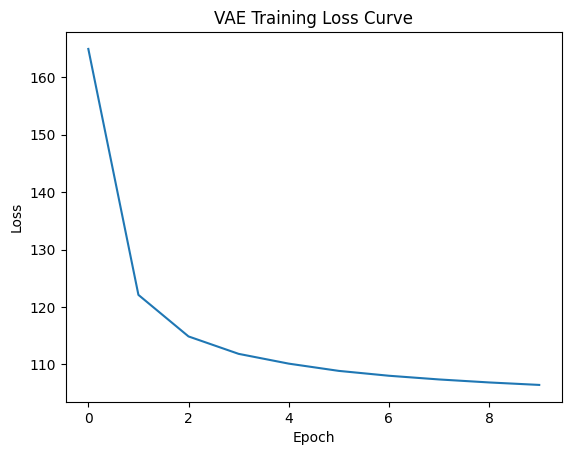

In [ ]:
# Plot loss vs epochs
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curve")
plt.show()


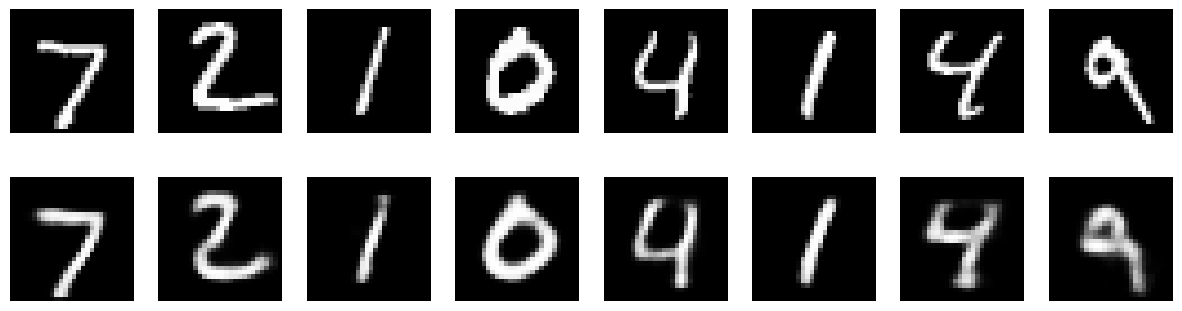

In [ ]:
# Switch to evaluation mode
model.eval()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.view(-1, 28*28).to(device)
    recon, _, _ = model(data)

    n = 8
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')

        # Reconstructed images
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()
